# <center> <u> **AutoML On Titanic Dataset** </u> </center>

# **Abstract**

In this notebook, we utilize the advanced capabilities of the H2O.ai AutoML library to analyze the Titanic dataset, with the primary objective of predicting passenger survival. The Titanic dataset, a historical record of passengers onboard the ill-fated maiden voyage of the Titanic, includes various features such as age, sex, passenger class, and fare, among others. The target variable for our predictive modeling is "Survived," indicating whether a passenger survived the sinking. By employing H2O.ai's AutoML, we aim to automatically explore numerous machine learning models and their configurations to identify the most effective predictors of survival. This approach allows us to bypass the exhaustive and time-consuming process of manual model selection and hyperparameter tuning. Our analysis seeks to uncover significant relationships within the data that contribute to a passenger's likelihood of survival, leveraging AutoML's capacity to rapidly iterate through algorithms and provide insights into the relative importance of features. Through this exploration, we aim to not only achieve high predictive accuracy but also gain deeper understanding of the factors that influenced survival rates during this historic tragedy.

In [81]:
import pandas as pd

In [82]:
url_train = 'https://raw.githubusercontent.com/kunaltibe7/datascienceengmethods/main/Titanic/titanic.csv'
df_train = pd.read_csv(url_train)
df_train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,1,22.0,1,0,7.2500,2
1,2,1,1,0,38.0,1,0,71.2833,0
2,3,1,3,0,26.0,0,0,7.9250,2
3,4,1,1,0,35.0,1,0,53.1000,2
4,5,0,3,1,35.0,0,0,8.0500,2


In [83]:
!pip install h2o

In [84]:
import h2o
from h2o.automl import H2OAutoML

In [85]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
import requests
from matplotlib import pyplot
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn import datasets, linear_model
from sklearn.metrics import accuracy_score,classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, SGDRegressor
from sklearn.model_selection import  train_test_split
from sklearn import metrics
from sklearn.model_selection import KFold
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [86]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,38 mins 36 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.3
H2O_cluster_version_age:,1 month and 29 days
H2O_cluster_name:,H2O_from_python_unknownUser_r0cg78
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.165 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


# Correlation between dataset variables

In [87]:
df_train.corr

<bound method DataFrame.corr of      PassengerId  Survived  Pclass  Sex   Age  SibSp  Parch     Fare  Embarked
0              1         0       3    1  22.0      1      0   7.2500         2
1              2         1       1    0  38.0      1      0  71.2833         0
2              3         1       3    0  26.0      0      0   7.9250         2
3              4         1       1    0  35.0      1      0  53.1000         2
4              5         0       3    1  35.0      0      0   8.0500         2
..           ...       ...     ...  ...   ...    ...    ...      ...       ...
886          887         0       2    1  27.0      0      0  13.0000         2
887          888         1       1    0  19.0      0      0  30.0000         2
888          889         0       3    0  15.0      1      2  23.4500         2
889          890         1       1    1  26.0      0      0  30.0000         0
890          891         0       3    1  32.0      0      0   7.7500         1

[891 rows x 9 columns]>

<Axes: >

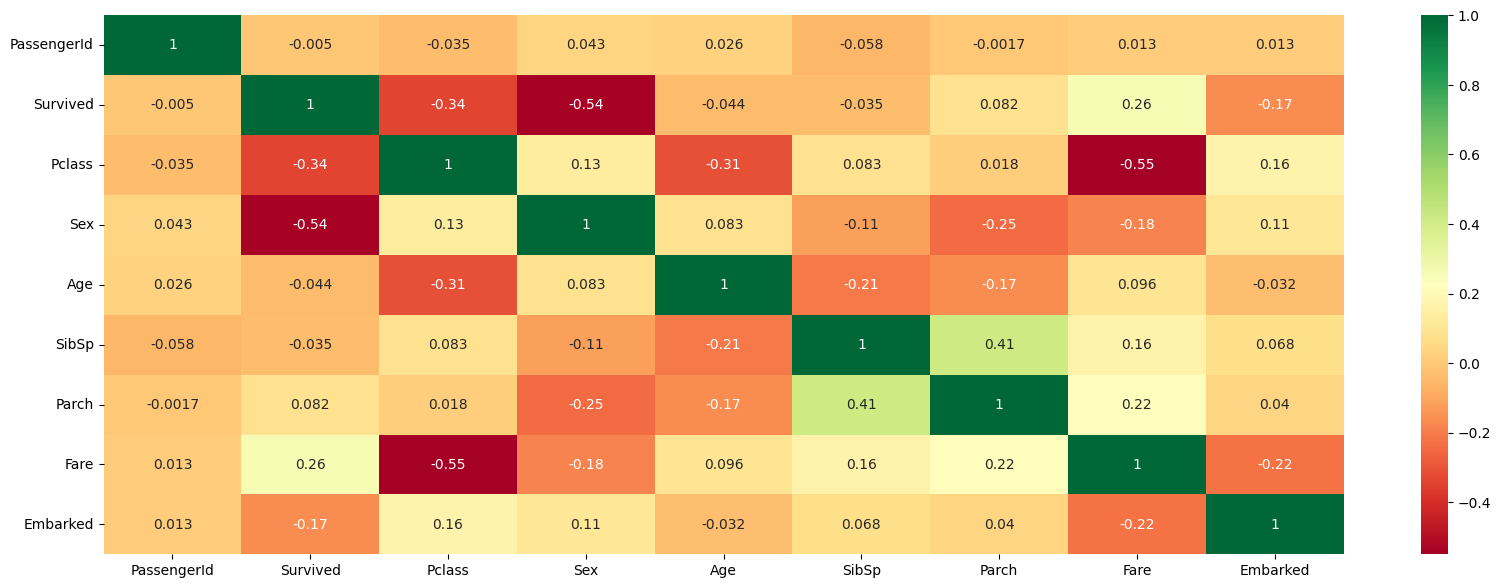

In [88]:
plt.figure(figsize=(20,7))
sns.heatmap(df_train.corr(), annot=True, cmap='RdYlGn')

# VIF Multicollinearity

In [89]:
df= df_train

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = df.columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(df.values, i)
                          for i in range(len(df.columns))]

print(vif_data)

       feature       VIF
0  PassengerId  3.773758
1     Survived  2.005304
2       Pclass  6.485979
3          Sex  3.771405
4          Age  4.423620
5        SibSp  1.576121
6        Parch  1.619370
7         Fare  1.896417
8     Embarked  4.687874


Yes, based on the provided Variance Inflation Factor (VIF) values, we can infer that multicollinearity exists in the dataset. A common rule of thumb is that a VIF value greater than 5 indicates a problematic level of multicollinearity. In this case, the "Pclass" feature has a VIF of 6.485979, which suggests significant multicollinearity. Other features have VIF values less than 5, indicating moderate to low multicollinearity, but the value for "Pclass" is enough to establish the presence of multicollinearity in the dataset.

# H2O

In [90]:
x = df_train.columns.tolist()
y = "Survived"
x.remove(y)

In [91]:
train_frame = h2o.H2OFrame(df_train)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [92]:
aml = H2OAutoML(max_models=10, seed=42, max_runtime_secs=7200)
aml.train(x=x, y=y, training_frame=train_frame)

AutoML progress: |
06:54:04.193: _response param, We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.

█
06:54:12.2: _response param, We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.

█
06:54:12.932: _response param, We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.


06:54:14.643: _response param, We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.

██
06:54:19.575: _response param, We have dete

key,value
Stacking strategy,cross_validation
Number of base models (used / total),4/5
# GBM base models (used / total),1/1
# XGBoost base models (used / total),1/1
# DRF base models (used / total),1/2
# GLM base models (used / total),1/1
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5
Metalearner fold_column,None


In [93]:
lb = aml.leaderboard
lb.head(rows=lb.nrows)

model_id,rmse,mse,mae,rmsle,mean_residual_deviance
StackedEnsemble_BestOfFamily_1_AutoML_2_20240219_65404,0.363768,0.132327,0.270402,0.256057,0.132327
StackedEnsemble_AllModels_1_AutoML_2_20240219_65404,0.364996,0.133222,0.272084,0.257184,0.133222
DRF_1_AutoML_2_20240219_65404,0.368702,0.135941,0.266054,0.260234,0.135941
GBM_2_AutoML_2_20240219_65404,0.369119,0.136249,0.276171,0.260066,0.136249
GBM_4_AutoML_2_20240219_65404,0.370793,0.137488,0.273203,0.261369,0.137488
GBM_3_AutoML_2_20240219_65404,0.37833,0.143133,0.284753,0.266468,0.143133
XGBoost_3_AutoML_2_20240219_65404,0.381514,0.145553,0.27897,0.268575,0.145553
GBM_1_AutoML_2_20240219_65404,0.383354,0.14696,0.306491,0.270657,0.14696
GLM_1_AutoML_2_20240219_65404,0.383814,0.147313,0.298755,0.271288,0.147313
XGBoost_1_AutoML_2_20240219_65404,0.387124,0.149865,0.285971,0.2766,0.149865


In [94]:
bestmodel= aml.leader
bestmodel

key,value
Stacking strategy,cross_validation
Number of base models (used / total),4/5
# GBM base models (used / total),1/1
# XGBoost base models (used / total),1/1
# DRF base models (used / total),1/2
# GLM base models (used / total),1/1
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5
Metalearner fold_column,None


# Predictor Relationship Significance

In [95]:
#Using OLS for finding the p value to check the significant features
import statsmodels.api as sm

model = sm.OLS(df_train['Survived'], df_train[['PassengerId', 'Pclass', 'Sex', 'Age',
       'SibSp', 'Parch', 'Fare', 'Embarked']]).fit()

# Print out the statistics
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               Survived   R-squared (uncentered):                   0.501
Model:                            OLS   Adj. R-squared (uncentered):              0.497
Method:                 Least Squares   F-statistic:                              111.0
Date:                Mon, 19 Feb 2024   Prob (F-statistic):                   7.13e-128
Time:                        06:54:41   Log-Likelihood:                         -527.72
No. Observations:                 891   AIC:                                      1071.
Df Residuals:                     883   BIC:                                      1110.
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
PassengerId     0.0003   5.48e-05      4.774      0.000       0.000       0.000
Pclass          0.0905      0.015      6.049      0.000       0.061       0.120
Sex            -0.4466      0.032    -13.873      0.000      -0.510      -0.383
Age             0.0049      0.001      5.286      0.000       0.003       0.007
SibSp          -0.0345      0.015     -2.284      0.023      -0.064      -0.005
Parch          -0.0064      0.021     -0.304      0.761      -0.048       0.035
Fare            0.0032      0.000      9.974      0.000       0.003       0.004
Embarked        0.0531      0.018      2.890      0.004       0.017       0.089
==============================================================================
Omnibus:                       47.246   Durbin-Watson:                   1.908
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               41.013
Skew:                           0.455   Prob(JB):                     1.24e-09
Kurtosis:                       2.473   Cond. No.                     1.16e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 1.16e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [96]:
train_frame = h2o.H2OFrame(df_train)

train, test = train_frame.split_frame(ratios=[.8], seed=1234)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [97]:
x = list(set(train.col_names) - set(["Survived"]))
y = "Survived"

In [98]:
preds = bestmodel.predict(test)
test_df = test.as_data_frame()
preds_df = preds.as_data_frame()
test_df.columns

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%


Index(['PassengerId', 'Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch',
       'Fare', 'Embarked'],
      dtype='object')

In [99]:
preds_df.columns

Index(['predict'], dtype='object')

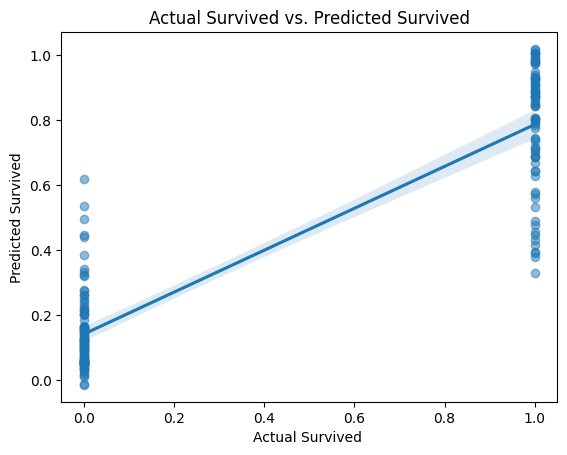

In [100]:
sns.regplot(x=test_df[y], y=preds_df['predict'], scatter_kws={'alpha': 0.5})
plt.xlabel('Actual Survived ')
plt.ylabel('Predicted Survived')
plt.title('Actual Survived vs. Predicted Survived')
plt.show()

A close alignment between predicted values and actual observed values signifies that the model has effectively learned the underlying patterns in the dataset and can generalize well to new, unseen data. The metrics from the graph serve as quantitative measures to assess the model's accuracy, where lower values indicate better predictive performance.

# Are there any assumptions violated?

In [101]:
test_frame = h2o.H2OFrame(test)


In [102]:
predictions = bestmodel.predict(test_frame)
predictions_frame = h2o.H2OFrame(predictions)
# Add predictions to test set
test_frame['Predicted'] = predictions


stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


Export File progress: |██████████████████████████████████████████████████████████| (done) 100%


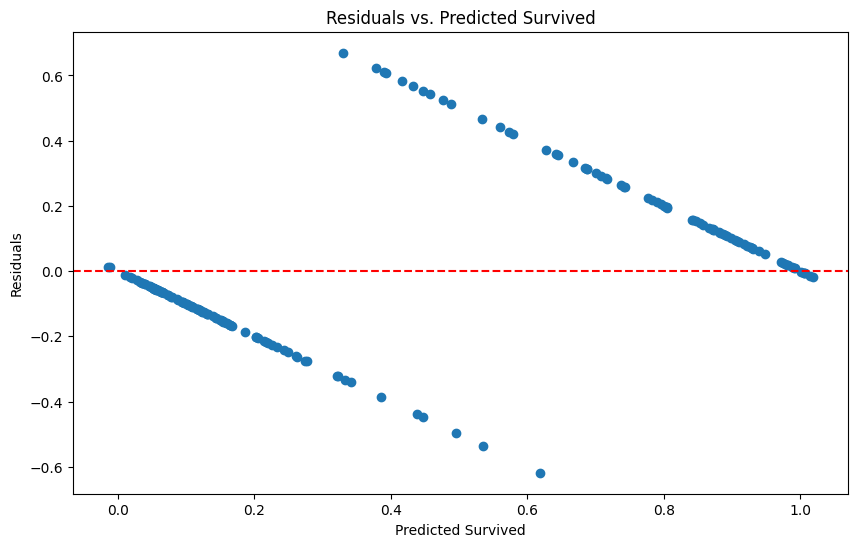

In [103]:
# Convert to pandas DataFrame
test_df = test_frame.as_data_frame()

residuals = test_df[y] - test_df['Predicted']

plt.figure(figsize=(10, 6))
plt.scatter(test_df['Predicted'], residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Survived')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Survived')
plt.show()


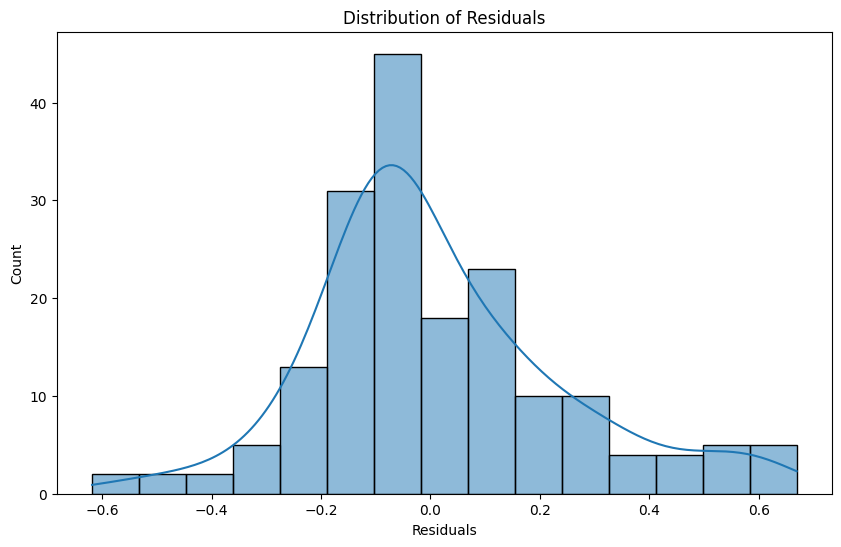

In [104]:
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.title('Distribution of Residuals')
plt.show()

The x-axis represents predicted prices, and the y-axis represents residuals (the difference between actual and predicted values).
The dashed red line at the 0 mark on the residuals axis indicates the baseline where residuals would be zero.
The red dots (data points) are scattered across the plot.
Notably, there is a pattern in the distribution of residuals. They are not evenly dispersed around the horizontal axis.
This lack of even dispersion suggests heteroscedasticity, meaning that the variance of residuals changes as predicted prices vary.
In summary, this graph does not exhibit homoscedasticity because the residuals do not show a consistent spread across different predicted price levels.

#  Is there any multicollinearity in the model?


Export File progress: |██████████████████████████████████████████████████████████| (done) 100%


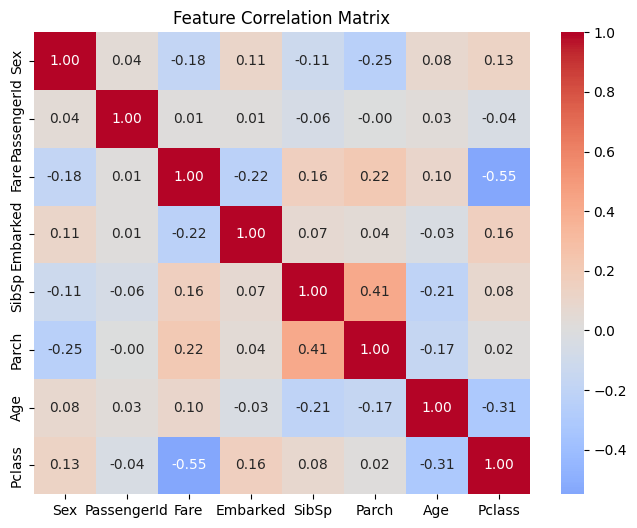

In [105]:
train_df = train_frame.as_data_frame(use_pandas=True)

features_df = train_df[x]

corr_matrix = features_df.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.show()

Yes, there is  **multicollinearity** in this feature correlation matrix. For instance, the correlation between **Pclass** and **Fare** is indicating a strong inverse relationship. **Multicollinearity** occurs when two or more predictor variables are highly correlated, which can lead to challenges in interpreting regression models. In this case, it's essential to consider the impact of correlated features on model performance and potentially address it through techniques like **ridge regression** or **principal components regression**⁷⁸.



#  In the multivariate models are predictor variables independent of all the other predictor variables?

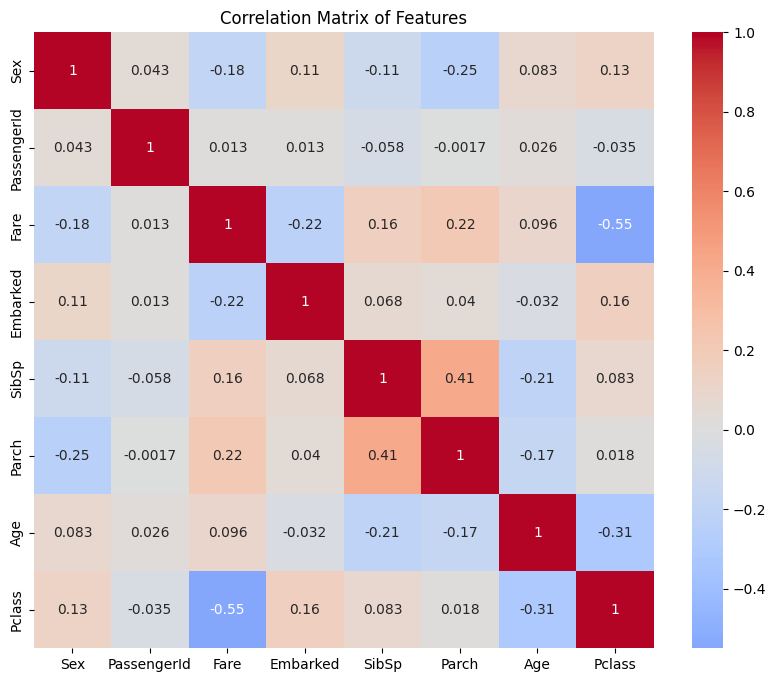

In [106]:
features_df = train_df[x]

corr_matrix = features_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Features')
plt.show()

The presence of correlations between predictor variables, such as the strong negative correlation between Pclass and Fare and the positive correlation between Parch and SibSp, indicates that these predictors are not independent of each other. This interdependence among variables suggests that changes in one variable are associated with changes in another

# In in multivariate models rank the most significant predictor variables and exclude insignificant ones from the model.


/usr/local/lib/python3.10/dist-packages/h2o/estimators/stackedensemble.py:965: H2ODeprecationWarning: The usage of stacked_ensemble.metalearner()['name'] will be deprecated. Metalearner now returns the metalearner object. If you need to get the 'name' please use stacked_ensemble.metalearner().model_id
  warnings.warn(


Variable importance for model DRF_1_AutoML_2_20240219_65404:


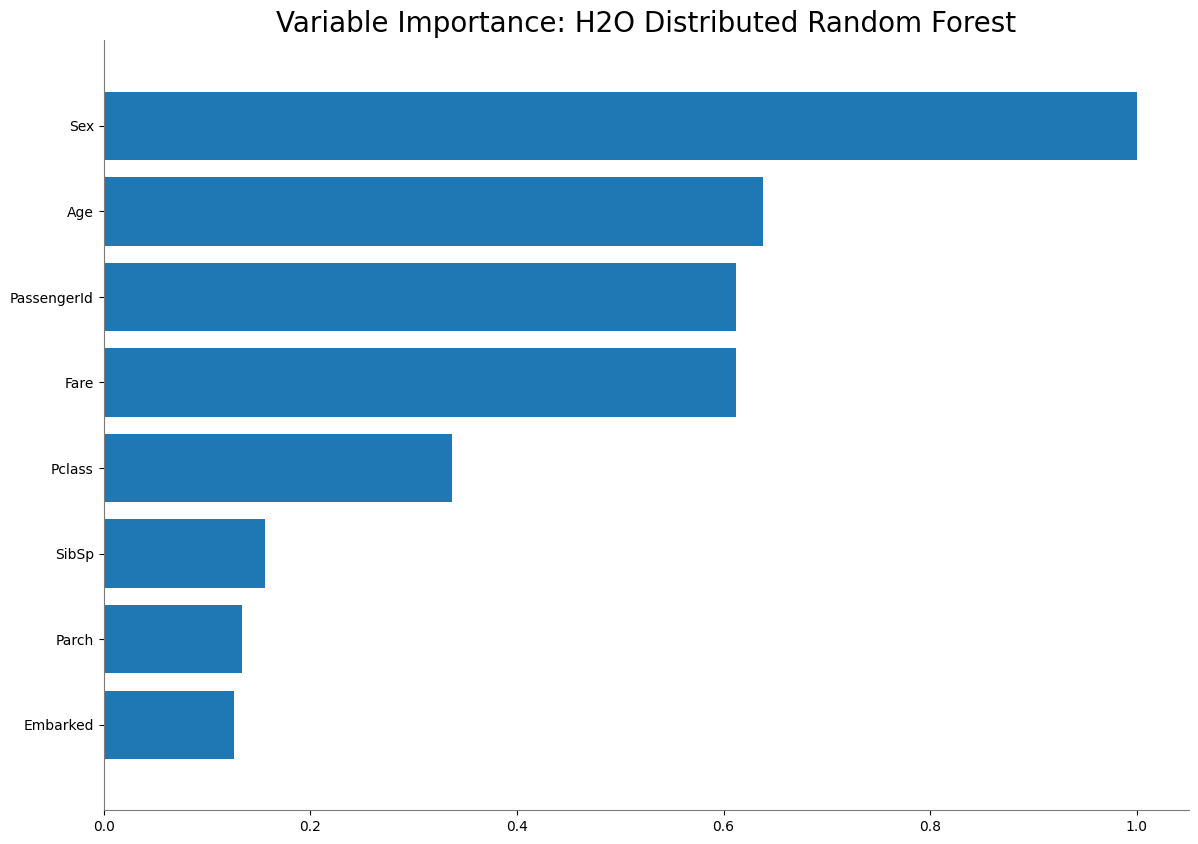

<Figure size 640x480 with 0 Axes>

In [107]:
metalearner = h2o.get_model(bestmodel.metalearner()['name'])

base_model_ids = list(metalearner.coef_norm().keys())[1:]
base_models = [h2o.get_model(mid) for mid in base_model_ids]

for base_model in base_models:
    if hasattr(base_model, 'varimp'):
        print(f"Variable importance for model {base_model.model_id}:")
        base_model.varimp_plot()
        break

A ranking of the most significant predictor variables:

Sex: Appears to be the most significant predictor.
Fare: Follows closely in importance.
Age: Also influential.
PassengerId and Pclass: Moderate importance.
SibSp, Parch, and Embarked: Less significant.

# Does the model make sense?

Export File progress: |██████████████████████████████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%


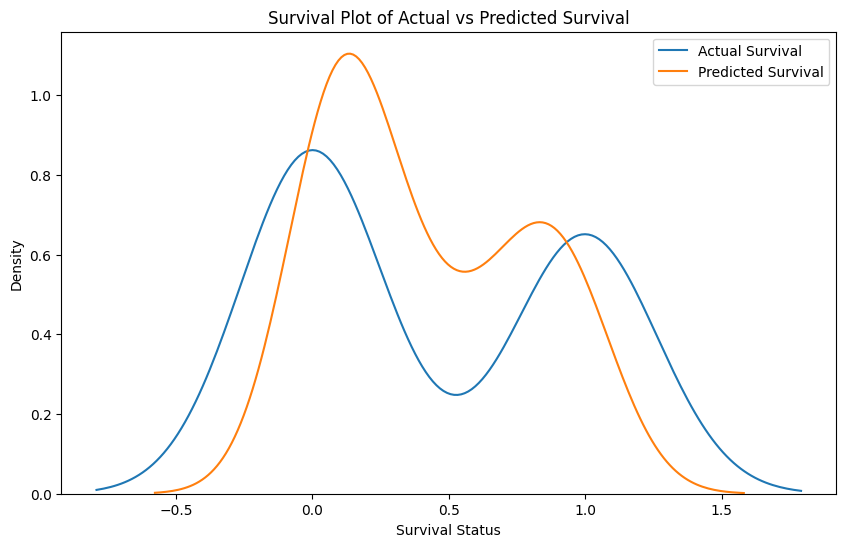

In [108]:
#Convert H2OFrame to Pandas DataFrame
test_df = test_frame.as_data_frame()
predictions_df = predictions_frame.as_data_frame()

#Extract actual and predicted values
actual_survived = test_df[y]
predicted_survived = predictions_df['predict']

plt.figure(figsize=(10, 6))
sns.kdeplot(actual_survived, label='Actual Survival', bw_adjust=1.5)
sns.kdeplot(predicted_survived, label='Predicted Survival', bw_adjust=1.5)
plt.xlabel('Survival Status')
plt.ylabel('Density')
plt.title('Survival Plot of Actual vs Predicted Survival')
plt.legend()
plt.show()


The Survival Plot comparing actual and predicted survival shows that the machine learning model broadly understands the data's patterns, accurately identifying trends in survival probabilities. However, differences in the peaks and shapes of the curves suggest the model's predictions are not perfectly aligned with reality, indicating overestimation or underestimation in certain areas. This reveals the model's effectiveness while also highlighting areas for improvement to enhance prediction accuracy.

# Regularization

In [109]:
X = df_train[['PassengerId','Pclass','Sex','Age','SibSp','Parch', 'Fare', 'Embarked' ]]

y = df_train['Survived']

#Spliting data into Training 70%, Test set 30%

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)




In [110]:
# Separate features and target variable for training data
X_train = train_df.drop('Survived', axis=1)
y_train = train_df['Survived']

# Initialize Ridge regression with an alpha of 0.5
ridge = Ridge(fit_intercept=True, alpha=0.5)

# Fit the model on the training data
ridge.fit(X_train, y_train)

Ridge(alpha=0.5)

In [111]:
# rmse after regularization
y_pred = ridge.predict(X_test)

rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print("rmse after regularization",rmse)

rmse after regularization 0.40462023833652594


RMSE for best_model : 0.369385724671478
rmse after regularization 0.40462023833652594
No, regularization does not help in this case because the RMSE increased after applying regularization, indicating worse model performance.

# Which independent variables are significant?

/usr/local/lib/python3.10/dist-packages/h2o/estimators/stackedensemble.py:965: H2ODeprecationWarning: The usage of stacked_ensemble.metalearner()['name'] will be deprecated. Metalearner now returns the metalearner object. If you need to get the 'name' please use stacked_ensemble.metalearner().model_id
  warnings.warn(


Variable importances for base model DRF_1_AutoML_2_20240219_65404:


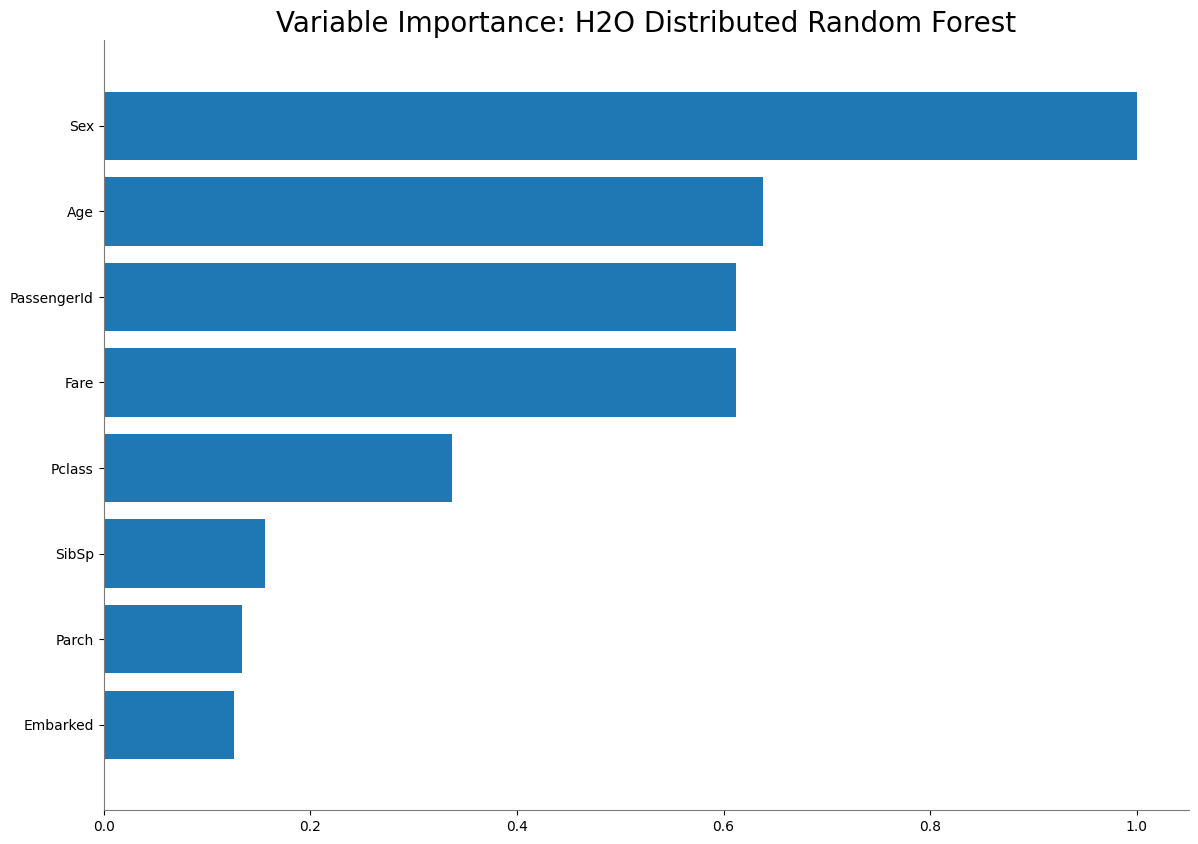

Variable importances for base model GBM_2_AutoML_2_20240219_65404:


<Figure size 640x480 with 0 Axes>

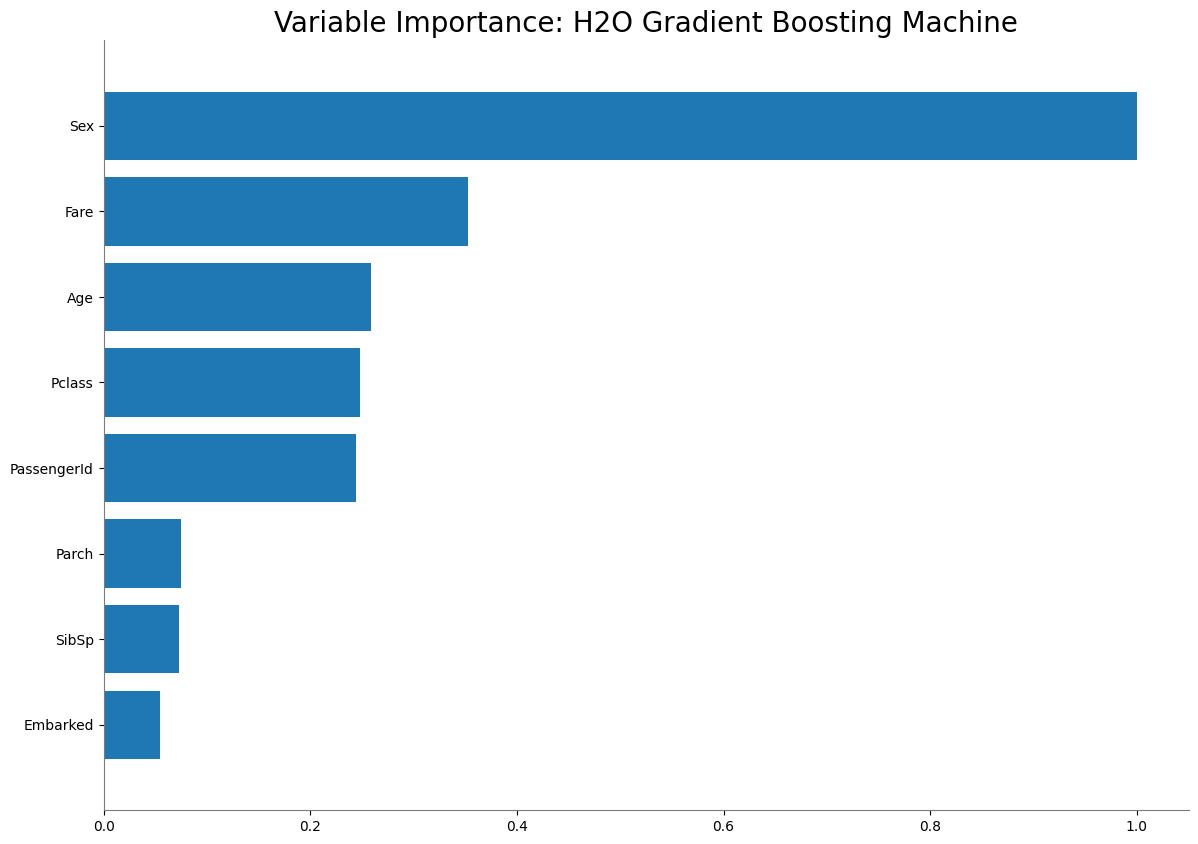

Variable importances for base model XGBoost_3_AutoML_2_20240219_65404:


<Figure size 640x480 with 0 Axes>

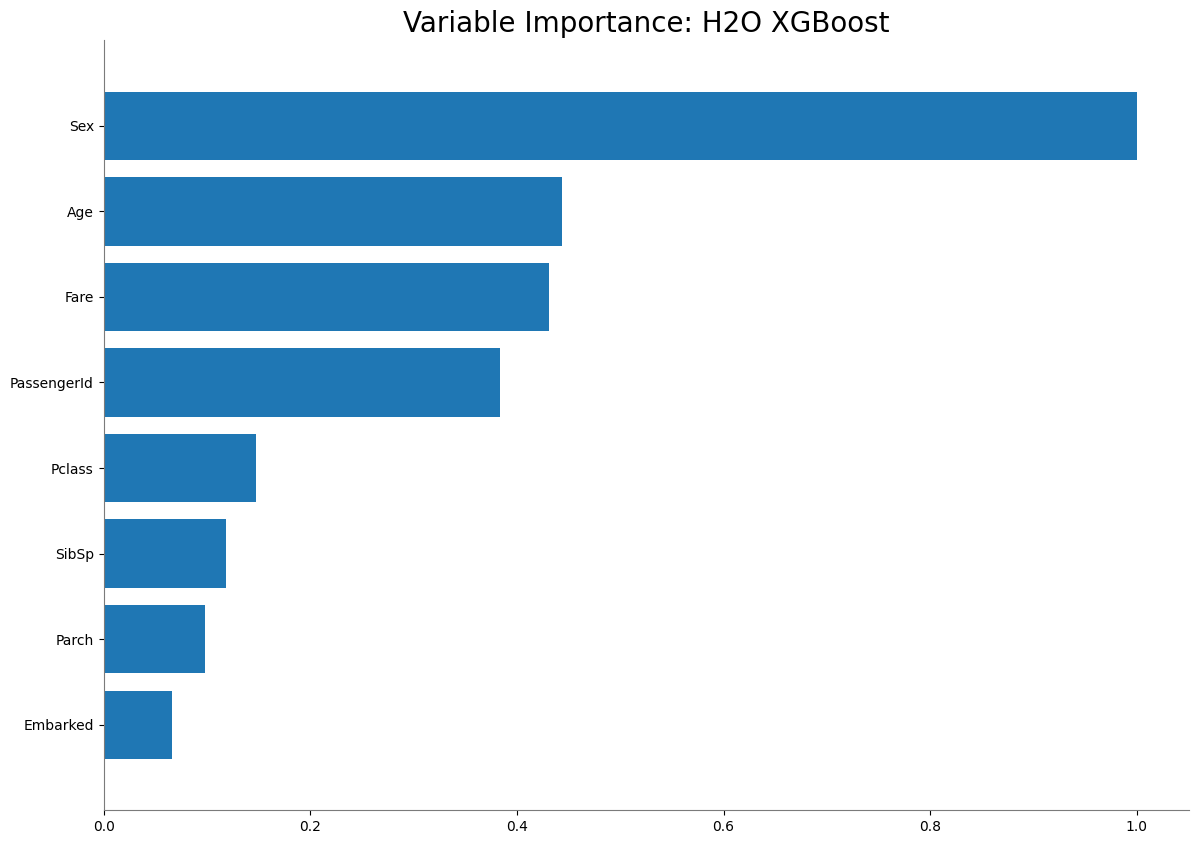

Variable importances for base model GLM_1_AutoML_2_20240219_65404:


<Figure size 640x480 with 0 Axes>

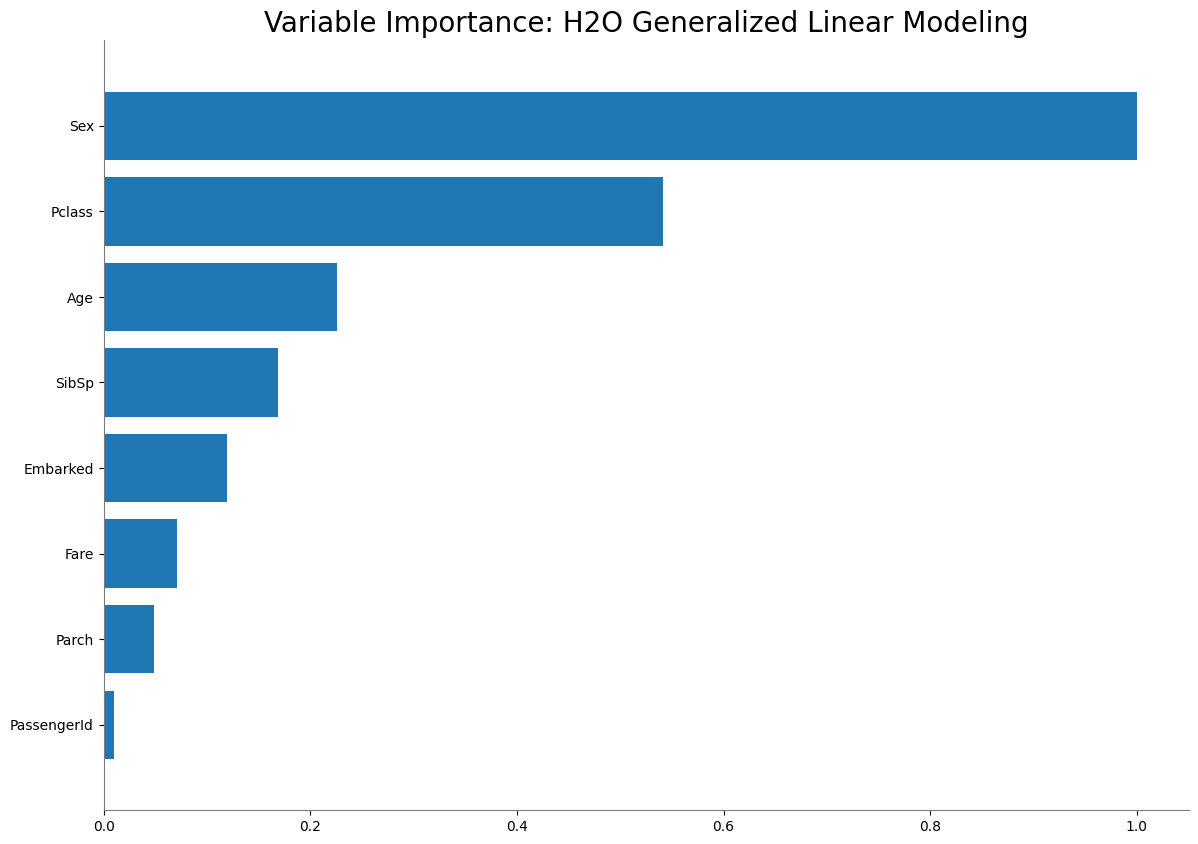

Variable importances for base model XRT_1_AutoML_2_20240219_65404:


<Figure size 640x480 with 0 Axes>

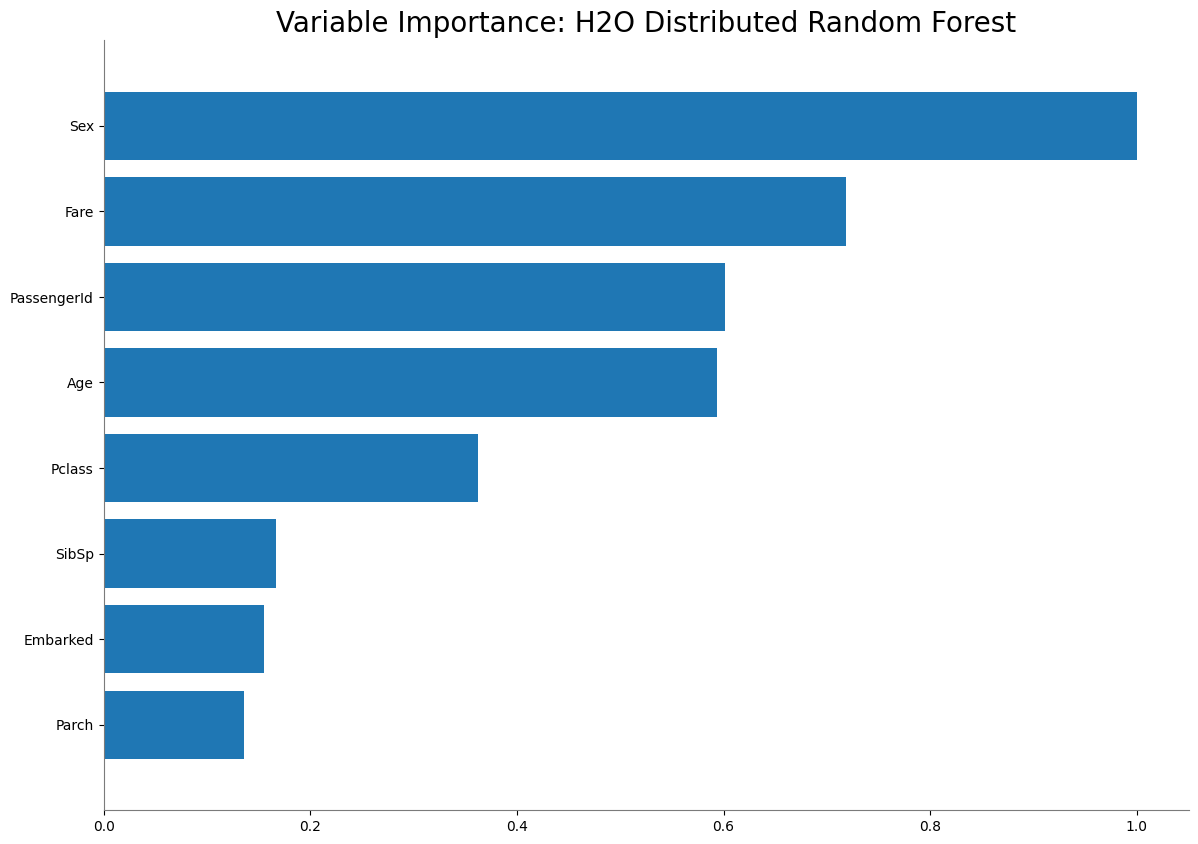

<Figure size 640x480 with 0 Axes>

In [112]:
best_model = aml.leader

# Check if the best model is a stacked ensemble
if 'StackedEnsemble' in best_model.model_id:
    # Retrieve the metalearner model
    metalearner = h2o.get_model(best_model.metalearner()['name'])

    # Extract the base models of the stacked ensemble
    base_models = [h2o.get_model(key['name']) for key in best_model.params['base_models']['actual']]

    # Loop over the base models to extract their variable importances
    for bm in base_models:
        if hasattr(bm, 'varimp'):
            print(f"Variable importances for base model {bm.model_id}:")
            # Display the variable importance plot
            bm.varimp_plot()
        else:
            print(f"Base model {bm.model_id} has no variable importances.")
else:
    print("The best model is not a stacked ensemble.")

# Which hyperparameters are important?

In [113]:
print(base_model.params)

{'model_id': {'default': None, 'actual': {'__meta': {'schema_version': 3, 'schema_name': 'ModelKeyV3', 'schema_type': 'Key<Model>'}, 'name': 'DRF_1_AutoML_2_20240219_65404', 'type': 'Key<Model>', 'URL': '/3/Models/DRF_1_AutoML_2_20240219_65404'}, 'input': None}, 'training_frame': {'default': None, 'actual': {'__meta': {'schema_version': 3, 'schema_name': 'FrameKeyV3', 'schema_type': 'Key<Frame>'}, 'name': 'AutoML_2_20240219_65404_training_Key_Frame__upload_be440ad66d4053c07faf1e3cfb7e410a.hex', 'type': 'Key<Frame>', 'URL': '/3/Frames/AutoML_2_20240219_65404_training_Key_Frame__upload_be440ad66d4053c07faf1e3cfb7e410a.hex'}, 'input': {'__meta': {'schema_version': 3, 'schema_name': 'FrameKeyV3', 'schema_type': 'Key<Frame>'}, 'name': 'AutoML_2_20240219_65404_training_Key_Frame__upload_be440ad66d4053c07faf1e3cfb7e410a.hex', 'type': 'Key<Frame>', 'URL': '/3/Frames/AutoML_2_20240219_65404_training_Key_Frame__upload_be440ad66d4053c07faf1e3cfb7e410a.hex'}}, 'validation_frame': {'default': None,

The important hyperparameters for the Gradient Boosting Machine (GBM) model are:

1. **`ntrees`** (Number of trees): It is set to 31 (actual) from an input of 10000, which indicates the model finalized with 31 trees to avoid overfitting or due to early stopping.

2. **`max_depth`** (Maximum depth of the trees): The actual value is 8, which controls the complexity of the model. A higher value can lead to more complex models, which might overfit.

3. **`min_rows`** (Minimum number of rows to make a split): Set to 10, this parameter helps in controlling the minimum size of the leaf nodes and thus helps in preventing overfitting.

4. **`sample_rate`** (Row sampling rate): With an actual value of 0.8, this parameter indicates that each tree was trained on 80% of the data instances, which helps in adding randomness and improving generalization.

5. **`col_sample_rate`** and **`col_sample_rate_per_tree`**: Both are set to 0.8, indicating that 80% of the features are used for training each tree, which helps in reducing overfitting and improving model robustness.

6. **`nfolds`**: The actual value is 5, indicating that 5-fold cross-validation was used for model validation, which helps in assessing the model's performance more reliably.

7. **`stopping_metric`** and **`stopping_tolerance`**: With "deviance" as the stopping metric and a tolerance of 0.038604571824109146, these parameters control when the training process should stop early to prevent overfitting.

8. **`learn_rate`**: The learning rate is 0.1, which determines the impact of each tree on the final outcome. A lower value makes the model more robust at the cost of requiring more trees.

These hyperparameters are crucial as they directly influence the model's ability to learn from the training data without overfitting, ensuring that the model generalizes well to unseen data.

# Conclusion

H2O AutoML's application for predicting the survival of passengers on the Titanic showcases its strengths as a comprehensive, efficient, and user-friendly tool for automated machine learning. By exploring a wide range of models, automatically tuning hyperparameters, and providing metrics for model evaluation, H2O simplifies the model-building process, making advanced predictive analytics accessible to users of varying expertise levels. Although it streamlines model selection and optimization, the importance of data understanding, preprocessing, and feature engineering remains paramount. Additionally, while H2O efficiently manages resources and scales well with data size, the effectiveness of its regularization and model complexity adjustments should be evaluated within the specific context of the problem being addressed. Overall, H2O AutoML represents a powerful solution for rapidly developing and deploying predictive models, as demonstrated in its application to the historically rich and complex Titanic dataset.

# References

- https://github.com/aiskunks/YouTube/blob/main/A_Crash_Course_in_Statistical_Learning/AutoML/AutoML_Smoke_Detection_Example.ipynb
- https://github.com/aiskunks/YouTube/blob/main/A_Crash_Course_in_Statistical_Learning/AutoML/CC_Kaggle_AutoML_Regression_Mel
- https://towardsdatascience.com/automated-machine-learning-with-h2o-258a2f3a203f
- https://docs.h2o.ai/h2o/latest-stable/h2o-docs/welcome.html
- https://www.youtube.com/watch?v=2JCoLTwOyFQ

# MIT LICENSE

In [114]:
url = 'https://raw.githubusercontent.com/kunaltibe7/datascienceengmethods/main/LICENSE'
license_text = requests.get(url).text
print(license_text)

MIT License

Copyright (c) 2024 Kunal Tibe

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTI